In [3]:
from __future__ import absolute_import, division, print_function
from builtins import (
    ascii, bytes, chr, dict, filter, hex, input, int, map,
    next, oct, open, pow, range, round, str, super, zip)

import os
from itertools import cycle
from functools import partial
import random
from math import pi

import psycopg2

# Imports for working with shapefiles
import pyproj
from shapely.geometry import shape, MultiPolygon
from shapely.ops import transform
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.colors import to_rgb
from matplotlib import cm
from matplotlib.patches import Polygon
%matplotlib inline

In [2]:
psql_pass = os.environ['PSQL_PASS']

In [3]:
conn = psycopg2.connect(
    database='wisc_gerry',
    user='pmende',
    password=psql_pass,
    host='localhost'
)

In [7]:
cur = conn.cursor()

In [5]:
cong_shp_file = 'data/districts/congressional/Wisconsin_Congressional_Districts.shp'

In [6]:
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), 
    pyproj.Proj(init='epsg:3695')
)

with fiona.open(cong_shp_file) as f:
    districts = [
        {
            'shape': transform(project, shape(polygon['geometry'])), 
             'District': polygon['properties']['District_N']
        }
        for polygon in f
    ]

for district in districts:
    district['area'] = district['shape'].area/(1000)**2
    district['perimeter'] = district['shape'].length/1000
    district['compactness'] = (
        4*pi*district['area']/district['perimeter']**2)
    print(district['compactness'])

0.156130911456
0.10856558407
0.153552056163
0.309567822477
0.237939579218
0.431576716393
0.166935192093
0.126339970508


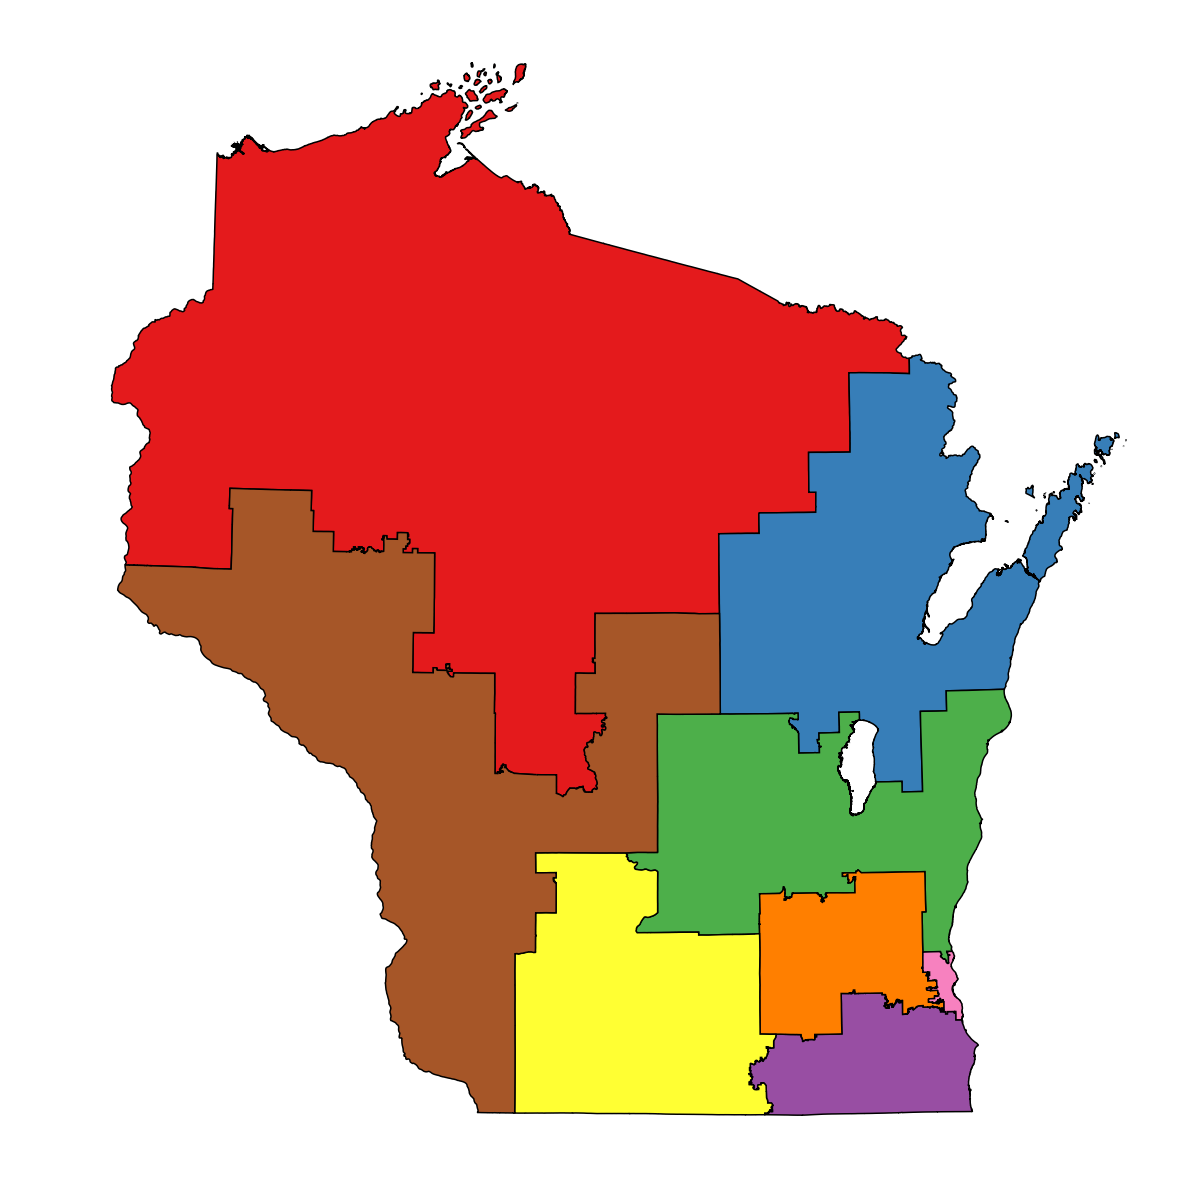

In [15]:
congressional_patches = [
    PolygonPatch(dis['shape'])
    for dis in districts
]

hex_colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
    '#ff7f00', '#ffff33', '#a65628', '#f781bf'
]
colors = [to_rgb(color) for color in hex_colors]
for patch, color in zip(congressional_patches, cycle(colors)):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

fig, ax = plt.subplots()

for patch in congressional_patches:
    ax.add_patch(patch)
    
ax.relim()
ax.autoscale_view()
ax.axis('off')
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
aspect_ratio = (ymax - ymin)/(xmax - xmin)
x_size = 20
fig.set_size_inches((x_size, x_size*aspect_ratio))

In [16]:
fig.savefig('images/congressional_districts.png', bbox_inches='tight')

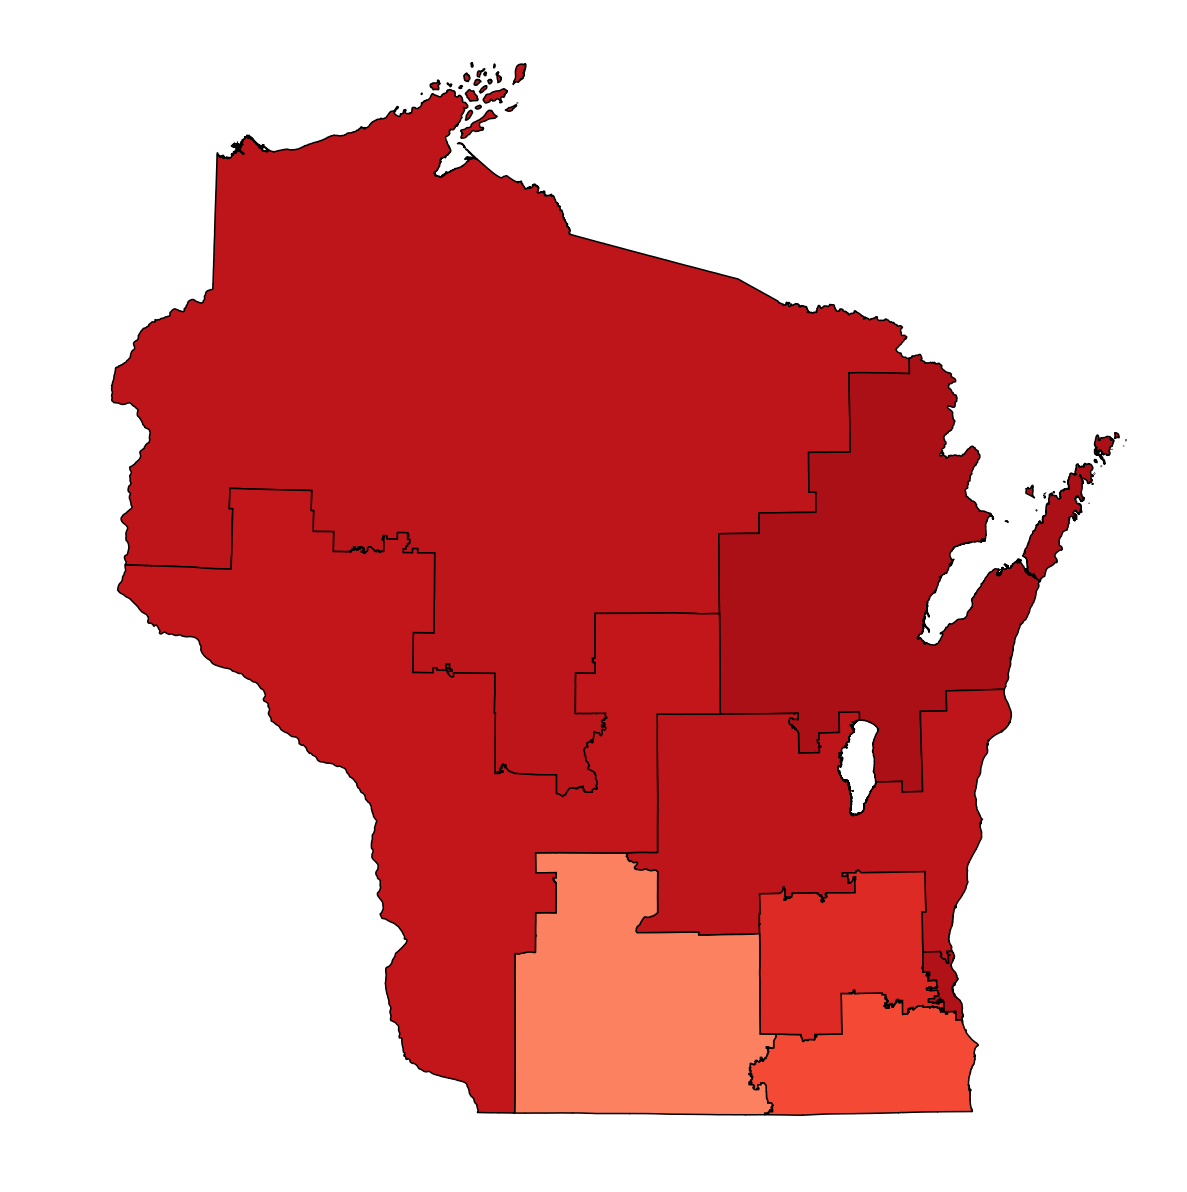

In [7]:
congressional_patches = [
    PolygonPatch(dis['shape'])
    for dis in districts
]

ref_aspect = 1.5
reference = 4*pi*(ref_aspect)/(2*(1+ref_aspect))**2
scale = cm.Reds_r
colors = [
    scale(dis['compactness']/reference)
    for dis in districts
]
for patch, color in zip(congressional_patches, cycle(colors)):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

fig, ax = plt.subplots(figsize=(20,20))

for patch in congressional_patches:
    ax.add_patch(patch)
    
ax.relim()
ax.autoscale_view()
ax.axis('off')
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
aspect_ratio = (ymax - ymin)/(xmax - xmin)
x_size = 20
fig.set_size_inches((x_size, x_size*aspect_ratio))

In [8]:
fig.savefig('images/congressional_compactness.png', bbox_inches='tight')

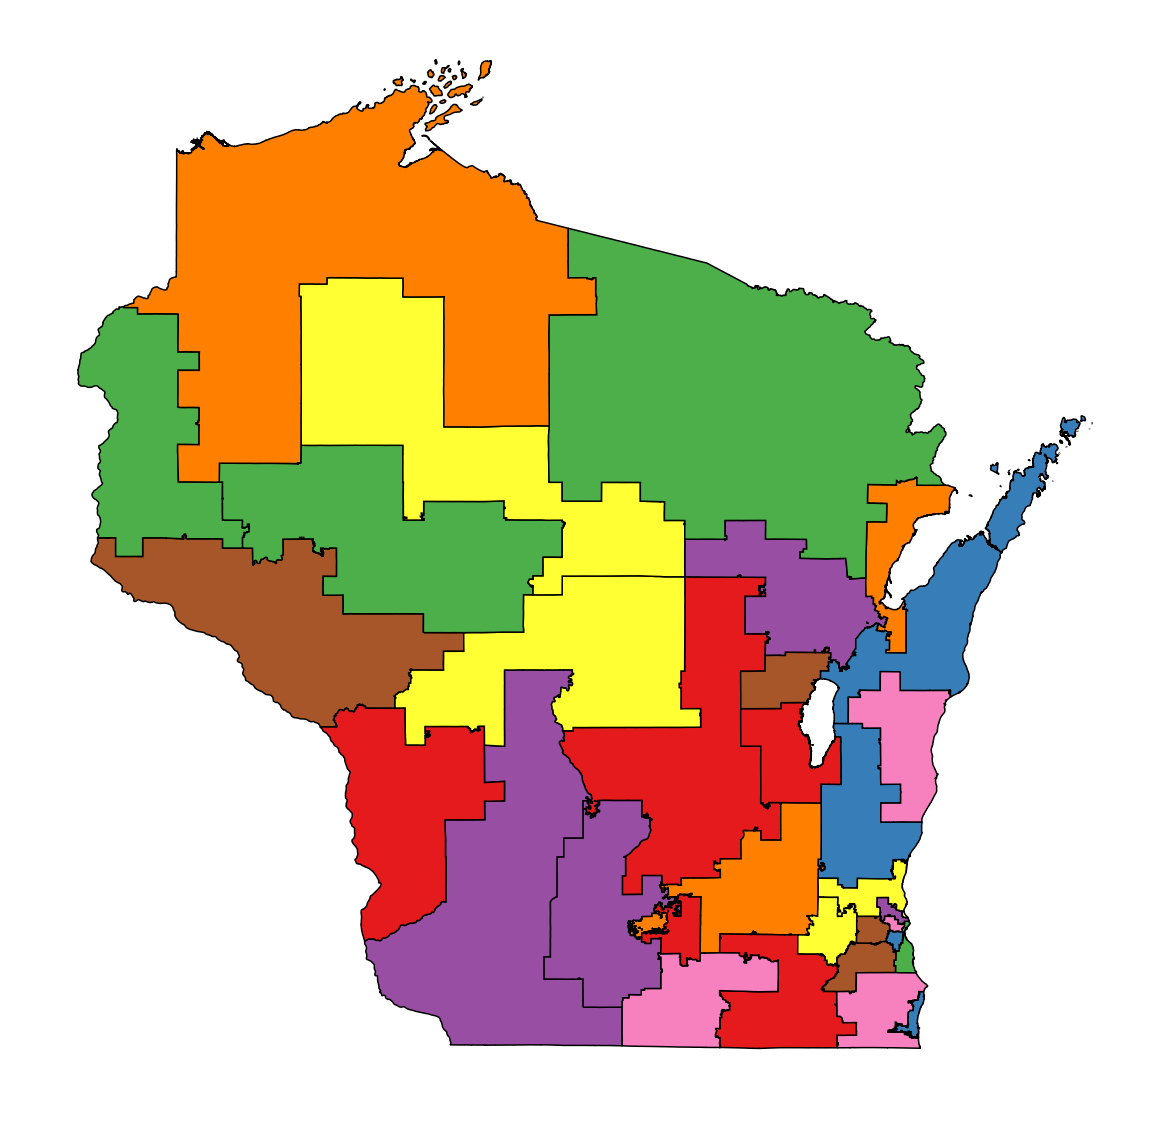

In [18]:
with fiona.open('data/districts/state_senate/Wisconsin_State_Senate_Districts.shp') as f:
    shapes = [shape(polygon['geometry']) for polygon in f]
    patches = [PolygonPatch(shp) for shp in shapes]

random.seed(385054)
random.shuffle(patches)
for patch, color in zip(patches, cycle(colors)):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

fig, ax = plt.subplots(figsize=(20,20))

for patch in patches:
    ax.add_patch(patch)
    
ax.relim()
ax.autoscale_view()
ax.axis('off');